In [1]:
import sys,time
sys.path.append('../')
from smodels.theory.tree import Tree, InclusiveParticleNode
from smodels.theory.auxiliaryFunctions import bracketToProcessStr
from smodels.experiment.defaultFinalStates import finalStates
from smodels.particlesLoader import BSMList
from smodels.share.models.SMparticles import SMList
from smodels.theory.model import Model
from smodels.theory.tree import sortTreeList,compareTrees,equalNodes,Tree
from smodels.tools.physicsUnits import fb, GeV
from smodels.theory.element import Element
import networkx as nx

### Element comparison

In [2]:
slhafile="../inputFiles/slha/lightEWinos.slha"
model = Model(BSMList,SMList)
model.updateParticles(inputFile=slhafile,promptWidth = 1e-12*GeV)

In [3]:
elA = Element("[ [ ['e-','nu'] ], [['ta+','ta-'],['u,u~']] ]",model=model,
              intermediateState=[['C1-'],['N2','gluino']], finalState=['N1','N1'])
elB = Element("[ ['*'], [ ['nu','L'] ] ]",model=finalStates,
              sort=False,finalState=['MET','MET'])
elC = Element("[ [ ['e-','q'] ], [['e+','ta-']] ]",model=model,
              intermediateState=[['C1-'],['N2','gluino']], finalState=['N1','C2+'])

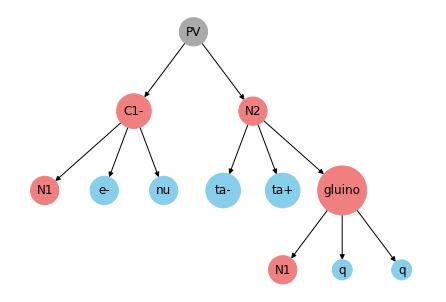

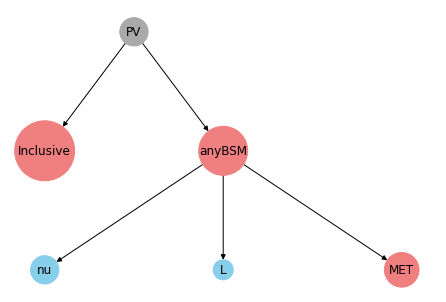

In [4]:
elA.drawTree()
elB.drawTree()

In [19]:
def getMatchesToInclusive(self,other,invert=False):
    """
    Compare self to a tree containing an inclusive tree.
    There is a match if other is a subtree of self and 
    the all final states appearing in the rest of self matches
    one of the SM or BSM final states in the inclusive node.
    Returns an iterator over the matching subtrees.
    
    The matched tree has its tree reduced to the subtree,
    with an InclusiveNode.
    
    :param other: Tree containing an InclusiveParticleNode
    :param invert: If True, will return the copy of the 
                   self subtree correspoding to other.
    
    :return: Iterator over the matching trees
    """
    
    # Define the matcher (other = subtree of self)    
    matcher = nx.algorithms.isomorphism.DiGraphMatcher(self,other,
                                                       node_match=equalNodes)
    matches = matcher.subgraph_isomorphisms_iter()
    for match in matches:
        if invert:
            match = {v : k for k,v in match.items()}
            sourceTree = self
            compTree = other
        else:
            sourceTree = other
            compTree = self
        
        # Make a copy of the source tree
        matchedTree = sourceTree.copyTree()

        # Remove all nodes and edges
        matchedTree.clear()
        # Store the nodes in the correct order:
        newNodes = []
        for n in compTree.nodes: # match = {compTree : sourceTree}
            if not n in match: # In case of inclusive nodes the match is partial
                continue
            if isinstance(n,InclusiveParticleNode):
                # Get deleted subtree
                delTree = Tree(nx.bfs_tree(sourceTree, source=match[n]))
                # Get all the final states in the deleted subtree
                finalStates = delTree.getFinalStates()
                # Check if the final states are allowed by the matching inclusive node
                if any((fs.particle not in n.finalStates) for fs in finalStates):
                    break
                # Replace the original node by a copy of the inclusive node
                newNode = n.copy()  
            else:
                # Make a copy of the original node
                newNode = match[n].copy()  
            newNode.node = n.node # Force the node numbering to be equal
            newNodes.append(newNode)
            match[n] = newNode  # Update the dictionary with the copied node
        else:
            # Store the edges in the correct order:
            newEdges = [(match[nA], match[nB]) for nA, nB in compTree.edges 
                        if (nA in match and nB in match)]
            # Add the nodes and the edges to the new tree:
            matchedTree.add_nodes_from(newNodes)
            matchedTree.add_edges_from(newEdges)
            matchedTree.setCanonName()
            yield matchedTree


In [20]:
def getMatchesTo(self,other,invert=False):
    """
    Check if self matches other.
    Returns a copy of other sorted according to how it matched self.
    
    :param other: Tree containing an InclusiveParticleNode
    :param invert: If True, will return the copy of the 
                   self sorted according to other.
    
    :return: Iterator over the matching trees
    """
    
    # Define the matcher (other = of self)    
    matcher = nx.algorithms.isomorphism.DiGraphMatcher(self,other,
                                                       node_match=equalNodes)
    matches = matcher.match()
    for match in matches:
        if invert:
            match = {v : k for k,v in match.items()}
            sourceTree = self
            compTree = other
        else:
            sourceTree = other
            compTree = self
        
        # Make a copy of the comparison tree
        matchedTree = compTree.copyTree()

        # Remove all nodes and edges
        matchedTree.clear()
        # Store the nodes in the correct order:
        newNodes = []
        for n in self.nodes:
            newNode = match[n].copy()  # match = {otherTree : sourceTree}
            newNode.node = n.node
            newNodes.append(newNode)
            match[n] = newNode  # Update the dictionary with the copied node

        # Store the edges in the correct order:
        newEdges = [(match[nA], match[nB]) for nA, nB in self.edges 
                    if (nA in match and nB in match)]
        # Add the nodes and the edges to the new tree:
        matchedTree.add_nodes_from(newNodes)
        matchedTree.add_edges_from(newEdges)
        matchedTree.setCanonName()
        yield matchedTree


In [21]:
def compareTree(self,other):

    # Make sure node attributes are set and updated:
    attrs = {n: n.__dict__ for n in self.nodes}
    nx.set_node_attributes(self, attrs)
    attrs = {n: n.__dict__ for n in other.nodes}
    nx.set_node_attributes(other, attrs)

    rootA = self.root
    rootB = other.root

    # Check for inclusive tree:
    if any(isinstance(d, InclusiveParticleNode) for d in self.successors(rootA)):
        # Check if self is a subgraph of other    
        matches = getMatchesToInclusive(other,self,invert=True)
    elif any(isinstance(d, InclusiveParticleNode) for d in other.successors(rootB)):
        # Check if other is a subgraph of self    
        matches = getMatchesToInclusive(self,other)
    else:
        matches = getMatchesToInclusive(self,other)
        
    for match in matches:
        yield match

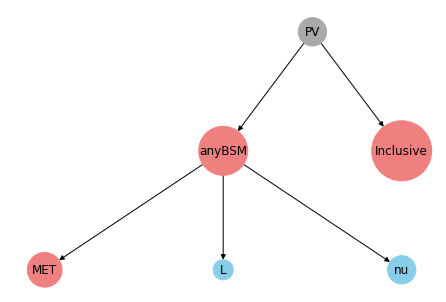

[PV, anyBSM, Inclusive, MET, L, nu]
[0, 1, 2, 3, 4, 5]
[(PV, anyBSM), (PV, Inclusive), (anyBSM, MET), (anyBSM, L), (anyBSM, nu)]


In [22]:
matched = next(compareTree(elA.tree,elB.tree))
matched.draw()
print(matched.nodes)
print([n.node for n in matched.nodes])
print(matched.edges)

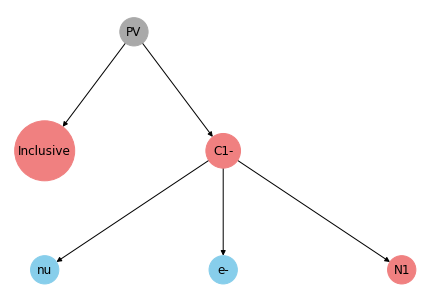

[PV, Inclusive, C1-, nu, e-, N1]
[0, 1, 2, 5, 6, 7]
[(PV, Inclusive), (PV, C1-), (C1-, nu), (C1-, e-), (C1-, N1)]


In [23]:
matched = next(compareTree(elB.tree,elA.tree))
matched.draw()
print(matched.nodes)
print([n.node for n in matched.nodes])
print(matched.edges)